In this notebook we produce an embedding using the technique of Node2vec similar to Word2vec (linguistic models). 
With this node embedding we compute the edge embedding and make a k-cross validation score against the weighted edges
of the network. 
The goal is to produce an embedding of edges that, given two nodes, provides the predicted sign of the link. 
For this purpose we have substituted the classes in the edges by only 2, positive and negative. 

In [1]:
import numpy as np
import pandas as pd 


import torch
import torch_geometric.data as data
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling,train_test_split_edges,to_dense_adj
from sklearn.metrics import roc_auc_score
from torch_geometric.transforms import RandomLinkSplit
from sklearn import preprocessing
from torch_geometric.nn import Node2Vec

device = "cpu"

In [2]:
nodes = pd.read_csv(r"Nodes_t2.csv",sep=",",encoding = 'unicode_escape')
edges = pd.read_csv(r"Edges_t2.csv",sep=",",encoding = 'unicode_escape')
edges["weight"] = edges["weight"].apply(lambda x: np.sign(x))
nodes[["ID"]] = nodes[["ID"]].apply(lambda x:x-edges["from"].min())
edges[["from","to"]] = edges[["from","to"]].apply(lambda x:x-edges["from"].min())
###Erase ESO 
nodes["Curso"] = nodes["Curso"].astype(str).str[0].astype("int64")
#del nodes["Unnamed: 0"]
nodes_dummy = pd.get_dummies(nodes)
x = nodes_dummy.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
nodes_norm = pd.DataFrame(x_scaled)

In [3]:
total_data = data.Data(x=torch.tensor(nodes_norm.to_numpy(),dtype=torch.float32),
                          edge_index=torch.tensor(edges[["from","to"]].to_numpy().T),
                          edge_attr=torch.tensor((pd.get_dummies(edges["weight"]).to_numpy())))

In [4]:
total_data

Data(x=[238, 32], edge_index=[2, 3755], edge_attr=[3755, 2])

In [5]:
import random as rd

node_list = list(range(len(nodes)))
rd.shuffle(node_list)
train_set = node_list[0:round(len(node_list)*0.7)]
val_set = node_list[round(len(node_list)*0.7):round(len(node_list)*0.85)]
test_set = node_list[round(len(node_list)*0.85):round(len(node_list)*1)]
rd.shuffle(test_set)
print(len(train_set),len(test_set),len(val_set))
print(len(train_set)+len(test_set)+len(val_set) == len(node_list))

print("train set\t",train_set[:10])
print("test set \t",test_set[:10])
print("val set  \t",val_set[:10])

167 36 35
True
train set	 [172, 53, 45, 77, 234, 166, 76, 187, 152, 237]
test set 	 [82, 217, 218, 147, 38, 227, 85, 120, 185, 191]
val set  	 [70, 146, 68, 125, 4, 99, 193, 107, 65, 126]


In [6]:
# build test train val masks

train_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in test_set:
    test_mask[i] = 1.
    
val_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in val_set:
    val_mask[i] = 1.
    
print("train mask \t",train_mask[0:15])
print("test mask  \t",test_mask[0:15])
print("val mask   \t",val_mask[0:15]) 

train mask 	 tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])
test mask  	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
val mask   	 tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [7]:
# add masks
total_data.train_mask = train_mask
total_data.test_mask = test_mask
total_data.val_mask = val_mask

print("after\t\t",total_data)

after		 Data(x=[238, 32], edge_index=[2, 3755], edge_attr=[3755, 2], train_mask=[238], test_mask=[238], val_mask=[238])


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(total_data.edge_index, embedding_dim=128, walk_length=40,
             context_size=20, walks_per_node=5,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.005)


In [9]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[total_data.train_mask], total_data.y[total_data.train_mask],
                     z[total_data.test_mask], total_data.y[total_data.test_mask],
                     max_iter=10)
    return acc


for epoch in range(1, 121):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
        

Epoch: 10, Loss: 6.0694
Epoch: 20, Loss: 5.0000
Epoch: 30, Loss: 4.2542
Epoch: 40, Loss: 3.8247
Epoch: 50, Loss: 3.4172
Epoch: 60, Loss: 3.0822
Epoch: 70, Loss: 2.8545
Epoch: 80, Loss: 2.6365
Epoch: 90, Loss: 2.4540
Epoch: 100, Loss: 2.3446
Epoch: 110, Loss: 2.2002
Epoch: 120, Loss: 2.0853


In [10]:
z = model()

In [11]:
# from tensor to numpy
emb_128 = z.detach().cpu().numpy()

In [12]:
# convert edge attributes from categorical to numerical
edge_attr_cat = total_data.edge_attr.numpy()
print("Categorical edge attributes:\n",edge_attr_cat[:3])

edge_attr = []
for i in edge_attr_cat:
    edge_attr.append(np.nonzero(i)[0][0])

print("\n\nNumerical edge attributes:\n",edge_attr[:3])

Categorical edge attributes:
 [[0 1]
 [0 1]
 [0 1]]


Numerical edge attributes:
 [1, 1, 1]


### Compute edge embedding

In [47]:
edge_embedding = []
for u,v in total_data.edge_index.t():
    edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0))
#edge_embedding = []
#for u,v in total_data.edge_index.t():
#    edge_embedding.append((abs(emb_128[u])/(abs(emb_128[u]) + abs(emb_128[v]))))

### Make dataframe from embedding and scale

In [48]:
emb_df = pd.concat([pd.DataFrame(edge_embedding),pd.DataFrame(edge_attr,columns=["label"])],axis=1)

In [49]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

In [50]:
X = emb_df.drop("label",axis=1)
y = emb_df["label"]

emb_x_train, emb_x_test, emb_y_train, emb_y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=emb_df["label"])

In [51]:
sc.fit(emb_x_train)
emb_x_train = sc.transform(emb_x_train)
emb_x_test = sc.transform(emb_x_test)

### Oversample minority class

In [52]:
from imblearn.over_sampling import SMOTE

In [53]:
ros = SMOTE(random_state=0,sampling_strategy="minority")
emb_x_resampled, emb_y_resampled = ros.fit_resample(emb_x_train, emb_y_train)
emb_y_resampled = emb_y_resampled.values
emb_y_test = emb_y_test.values

### Training and prediction 

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [55]:
clf = RandomForestClassifier(max_depth=7,random_state=10,class_weight="balanced")


In [56]:
clf.fit(emb_x_resampled,emb_y_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=7, random_state=10)



              precision    recall  f1-score   support

           0       0.28      0.46      0.34        72
           1       0.94      0.87      0.90       679

    accuracy                           0.83       751
   macro avg       0.61      0.67      0.62       751
weighted avg       0.87      0.83      0.85       751



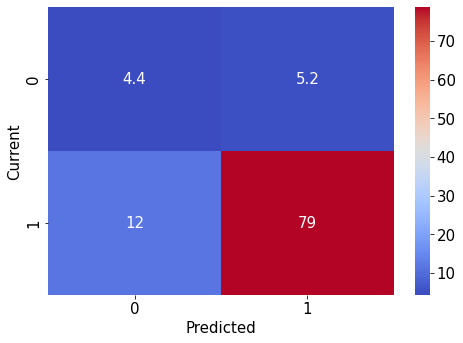

In [57]:
from sklearn.metrics import confusion_matrix,classification_report
fig= plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.heatmap(np.round(confusion_matrix(emb_y_test,np.around(clf.predict(emb_x_test)))/len(emb_y_test)*100,2),
            annot=True,ax=ax,cmap="coolwarm")
ax.set_xlabel("Predicted")
ax.set_ylabel("Current")
print("\n")
print(classification_report(emb_y_test,clf.predict(emb_x_test)))


In [58]:
import tensorflow as tf

In [69]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu",input_shape=(emb_x_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=10e-5),
         loss="binary_crossentropy",
             metrics=["accuracy"])
model_history = model.fit(emb_x_resampled,emb_y_resampled,validation_data=(emb_x_test,emb_y_test),epochs=250,verbose=1,batch_size=128,
                         #callbacks=[tf.keras.callbacks.EarlyStopping(patience=25)])
                         )

Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/home/juan/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


39/43 [==========================>...] - ETA: 0s - loss: 0.7549 - accuracy: 0.5014WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f75b577fd30> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
43/43 [==============================] - 1s 8ms/step - loss: 0.7524 - accuracy: 0.5018 - val_loss: 0.6743 - val_accuracy: 0.8868
Epoch 2/250
43/43 [===============

Epoch 52/250
43/43 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.6231 - val_loss: 0.6362 - val_accuracy: 0.6511
Epoch 53/250
43/43 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.6183 - val_loss: 0.5962 - val_accuracy: 0.7577
Epoch 54/250
43/43 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.6188 - val_loss: 0.6319 - val_accuracy: 0.6285
Epoch 55/250
43/43 [==============================] - 0s 5ms/step - loss: 0.6462 - accuracy: 0.6411 - val_loss: 0.5924 - val_accuracy: 0.7310
Epoch 56/250
43/43 [==============================] - 0s 5ms/step - loss: 0.6388 - accuracy: 0.6461 - val_loss: 0.6001 - val_accuracy: 0.7044
Epoch 57/250
43/43 [==============================] - 0s 8ms/step - loss: 0.6398 - accuracy: 0.6483 - val_loss: 0.5896 - val_accuracy: 0.7257
Epoch 58/250
43/43 [==============================] - 0s 7ms/step - loss: 0.6340 - accuracy: 0.6562 - val_loss: 0.5825 - val_accuracy: 0.7337
Epoch 

43/43 [==============================] - 0s 6ms/step - loss: 0.4534 - accuracy: 0.8063 - val_loss: 0.3549 - val_accuracy: 0.8402
Epoch 110/250
43/43 [==============================] - 0s 6ms/step - loss: 0.4473 - accuracy: 0.8063 - val_loss: 0.3981 - val_accuracy: 0.8176
Epoch 111/250
43/43 [==============================] - 0s 5ms/step - loss: 0.4469 - accuracy: 0.8113 - val_loss: 0.3640 - val_accuracy: 0.8269
Epoch 112/250
43/43 [==============================] - 0s 6ms/step - loss: 0.4481 - accuracy: 0.8188 - val_loss: 0.3673 - val_accuracy: 0.8322
Epoch 113/250
43/43 [==============================] - 0s 5ms/step - loss: 0.4503 - accuracy: 0.8151 - val_loss: 0.3673 - val_accuracy: 0.8309
Epoch 114/250
43/43 [==============================] - 0s 5ms/step - loss: 0.4446 - accuracy: 0.8155 - val_loss: 0.3599 - val_accuracy: 0.8389
Epoch 115/250
43/43 [==============================] - 0s 5ms/step - loss: 0.4310 - accuracy: 0.8236 - val_loss: 0.3613 - val_accuracy: 0.8322
Epoch 116/250

43/43 [==============================] - 0s 5ms/step - loss: 0.3413 - accuracy: 0.8701 - val_loss: 0.3252 - val_accuracy: 0.8695
Epoch 167/250
43/43 [==============================] - 0s 5ms/step - loss: 0.3222 - accuracy: 0.8753 - val_loss: 0.3325 - val_accuracy: 0.8695
Epoch 168/250
43/43 [==============================] - 0s 5ms/step - loss: 0.3367 - accuracy: 0.8690 - val_loss: 0.3175 - val_accuracy: 0.8695
Epoch 169/250
43/43 [==============================] - 0s 5ms/step - loss: 0.3323 - accuracy: 0.8688 - val_loss: 0.3278 - val_accuracy: 0.8695
Epoch 170/250
43/43 [==============================] - 0s 5ms/step - loss: 0.3290 - accuracy: 0.8753 - val_loss: 0.3307 - val_accuracy: 0.8735
Epoch 171/250
43/43 [==============================] - 0s 5ms/step - loss: 0.3154 - accuracy: 0.8850 - val_loss: 0.3313 - val_accuracy: 0.8722
Epoch 172/250
43/43 [==============================] - 0s 5ms/step - loss: 0.3158 - accuracy: 0.8766 - val_loss: 0.3309 - val_accuracy: 0.8695
Epoch 173/250

43/43 [==============================] - 0s 5ms/step - loss: 0.2662 - accuracy: 0.8992 - val_loss: 0.3551 - val_accuracy: 0.8842
Epoch 224/250
43/43 [==============================] - 0s 5ms/step - loss: 0.2779 - accuracy: 0.8935 - val_loss: 0.3519 - val_accuracy: 0.8868
Epoch 225/250
43/43 [==============================] - 0s 5ms/step - loss: 0.2668 - accuracy: 0.8992 - val_loss: 0.3525 - val_accuracy: 0.8855
Epoch 226/250
43/43 [==============================] - 0s 6ms/step - loss: 0.2711 - accuracy: 0.8968 - val_loss: 0.3511 - val_accuracy: 0.8881
Epoch 227/250
43/43 [==============================] - 0s 5ms/step - loss: 0.2612 - accuracy: 0.9053 - val_loss: 0.3551 - val_accuracy: 0.8855
Epoch 228/250
43/43 [==============================] - 0s 5ms/step - loss: 0.2608 - accuracy: 0.9036 - val_loss: 0.3523 - val_accuracy: 0.8908
Epoch 229/250
43/43 [==============================] - 0s 5ms/step - loss: 0.2688 - accuracy: 0.9045 - val_loss: 0.3632 - val_accuracy: 0.8881
Epoch 230/250

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


              precision    recall  f1-score   support

           0       0.43      0.42      0.42        72
           1       0.94      0.94      0.94       679

    accuracy                           0.89       751
   macro avg       0.68      0.68      0.68       751
weighted avg       0.89      0.89      0.89       751



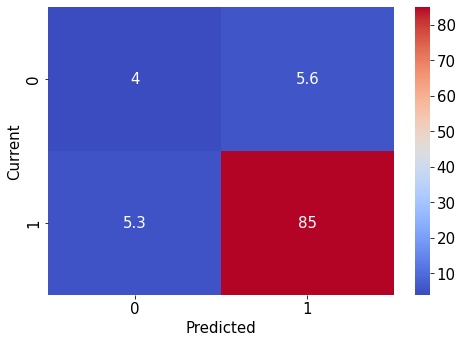

In [70]:
from sklearn.metrics import confusion_matrix,classification_report
fig= plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.heatmap(np.round(confusion_matrix(emb_y_test,np.around(model.predict(emb_x_test)))/len(emb_y_test)*100,2),
            annot=True,ax=ax,cmap="coolwarm")
ax.set_xlabel("Predicted")
ax.set_ylabel("Current")
print("\n")
print(classification_report(emb_y_test,np.around(model.predict(emb_x_test))))


<AxesSubplot:>

<Figure size 864x576 with 0 Axes>

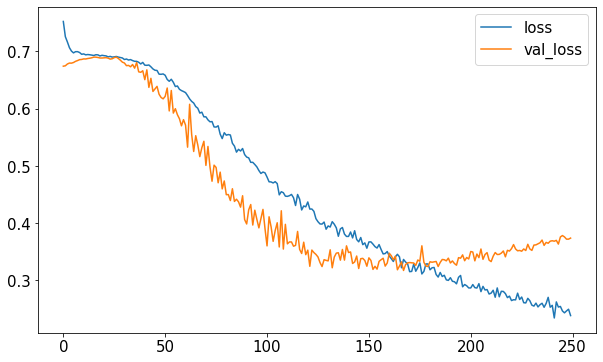

In [71]:
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 15})
pd.DataFrame(model_history.history)[["loss","val_loss"]].plot(figsize=(10,6))

<AxesSubplot:>

<Figure size 864x576 with 0 Axes>

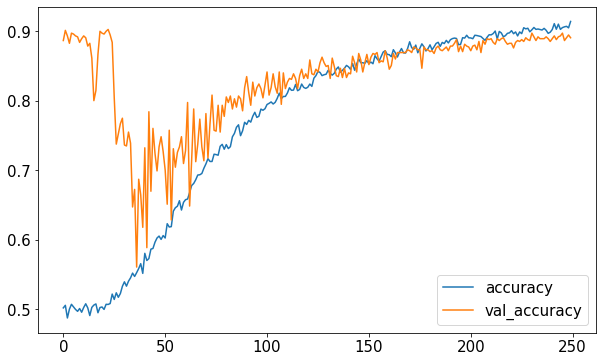

In [72]:
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 15})
pd.DataFrame(model_history.history)[["accuracy","val_accuracy"]].plot(figsize=(10,6))

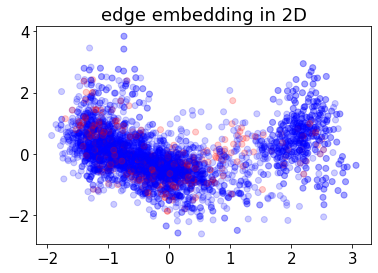

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
edge_emb2d = pca.fit_transform(X)



df = pd.DataFrame(dict(edge_att=y))
colors = {0:"red",1:"blue"}
plt.title("edge embedding in 2D")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1],c=df.edge_att.map(colors),alpha=0.2)
plt.show()

# not so good but we are using PCA to reduce the dim from 128 to 2